In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Paths (Change to point to chest X-ray dataset root)
DATA_DIR = '/content/drive/MyDrive/Pneumonia_Detection/chest_xray'  # should contain /train, /val, /test folders

# ✅ Parameters
IMG_SIZE = (224, 224)  # Recommended for MobileNetV2
BATCH_SIZE = 32
EPOCHS = 10

# ✅ Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR + '/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Only 2 classes: NORMAL, PNEUMONIA
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR + '/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# ✅ Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# ✅ Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

# ✅ Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)

# ✅ Save Model
model.save('/content/drive/MyDrive/Pneumonia_Detection//pneumonia_mobilenetv2.keras')


Found 4179 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - accuracy: 0.7712 - loss: 0.4821 - val_accuracy: 0.8937 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.9144 - loss: 0.2030 - val_accuracy: 0.9157 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9217 - loss: 0.1837 - val_accuracy: 0.9234 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9398 - loss: 0.1601 - val_accuracy: 0.9310 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9347 - loss: 0.1605 - val_accuracy: 0.8994 - val_loss: 0.2328 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9451 - loss: 0.1370
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
131/131 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.9451 - loss: 0.136

In [13]:
# Load test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pneumonia_Detection/chest_xray/test',  # ✅ path to test folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [14]:
# Predict probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Get true labels
y_true = test_generator.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.87      0.87       234
   PNEUMONIA       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



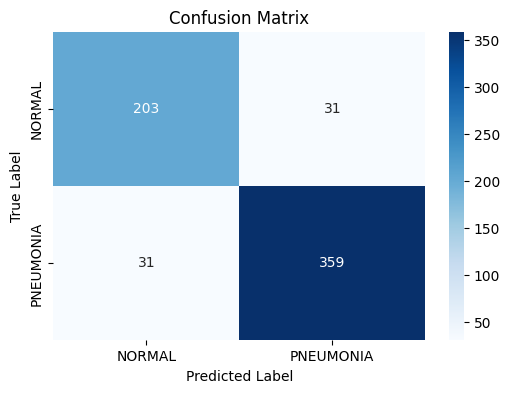

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
